Image Classification (Oxford-IIIT Pet Dataset)

(Notebook implemented in Kaggle Kernel)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
bs = 64
# bs = 16   # decreased batch size for less powerful GPUs

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. 
We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [4]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



In [5]:
path = untar_data(URLs.PETS); path

PosixPath('/tmp/.fastai/data/oxford-iiit-pet')

In [6]:
path.ls()

[PosixPath('/tmp/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/tmp/.fastai/data/oxford-iiit-pet/annotations')]

In [7]:
path_anno = path/'annotations'
path_img = path/'images'

Taking a look at the data:

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories.The fastai library has a funciton called `ImageDataBunch.from_name_re` that gets the labels from the filenames using a Regex.

In [8]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/tmp/.fastai/data/oxford-iiit-pet/images/american_bulldog_7.jpg'),
 PosixPath('/tmp/.fastai/data/oxford-iiit-pet/images/Bengal_199.jpg'),
 PosixPath('/tmp/.fastai/data/oxford-iiit-pet/images/Maine_Coon_17.jpg'),
 PosixPath('/tmp/.fastai/data/oxford-iiit-pet/images/Maine_Coon_94.jpg'),
 PosixPath('/tmp/.fastai/data/oxford-iiit-pet/images/havanese_94.jpg')]

In [9]:
np.random.seed(2)
pat = re.compile(r'/([^/]+)_\d+.jpg$')

In [10]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs, num_workers=0
                                  ).normalize(imagenet_stats)

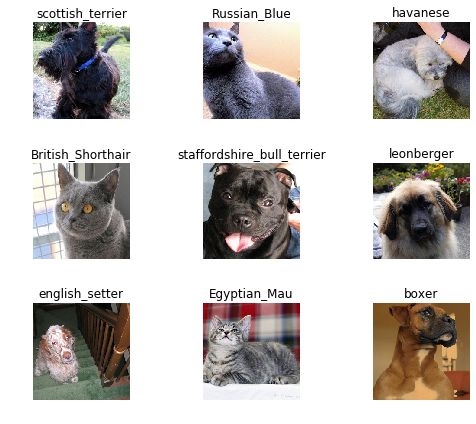

In [11]:
data.show_batch(rows=3, figsize=(7,6))

In [12]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. 
We will train for 4 epochs (4 cycles through all our data).

In [13]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/opt/conda/lib/python3.6/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
87306240it [00:00, 114213638.26it/s]


In [14]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.405409,0.331157,0.093369,02:10
1,0.559655,0.235328,0.073072,02:08
2,0.348675,0.199836,0.056157,02:08
3,0.268969,0.187943,0.061570,02:09


In [15]:
learn.save('stage-1')

## Results

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable. This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

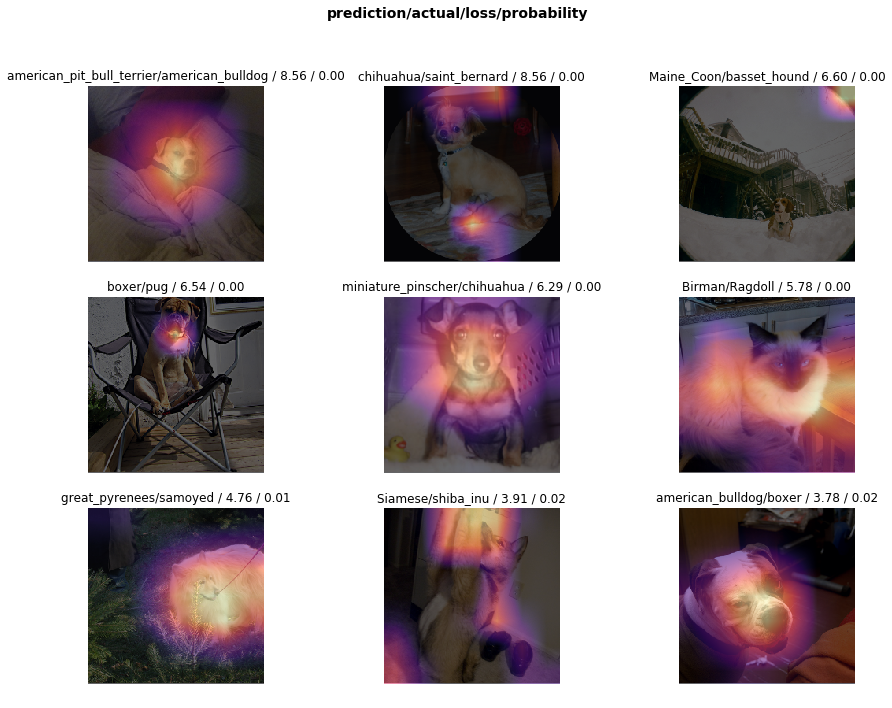

In [17]:
interp.plot_top_losses(9, figsize=(15,11))

In [18]:
doc(interp.plot_top_losses)

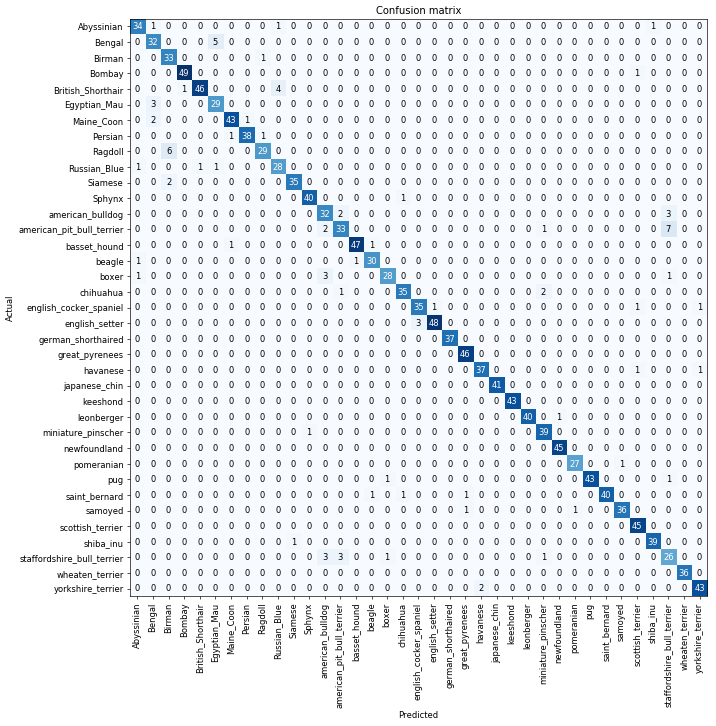

In [19]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [20]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 7),
 ('Ragdoll', 'Birman', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('Egyptian_Mau', 'Bengal', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 3),
 ('boxer', 'american_bulldog', 3),
 ('english_setter', 'english_cocker_spaniel', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3),
 ('Maine_Coon', 'Bengal', 2),
 ('Siamese', 'Birman', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2),
 ('american_pit_bull_terrier', 'american_bulldog', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('yorkshire_terrier', 'havanese', 2)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [21]:
learn.unfreeze()

In [22]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.520446,0.313737,0.096752,02:09


In [23]:
learn.load('stage-1');

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


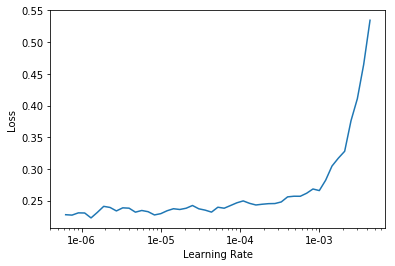

In [25]:
learn.recorder.plot()

In [26]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.232638,0.185768,0.063599,02:13
1,0.206764,0.180508,0.058187,02:13


High accuracy model achieved.

## Training: resnet50

ResNet 34 replaced with ResNet 50 to observe change in performance.

resnet50 usually performs better because it is a deeper network with more parameters. Larger images are used, since that way the network can see more detail. Batch size reduced to accomodate to the GPU Memory.

In [27]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2, num_workers=0).normalize(imagenet_stats)

In [28]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

/opt/conda/lib/python3.6/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.torch/models/resnet50-19c8e357.pth
102502400it [00:00, 117665409.53it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


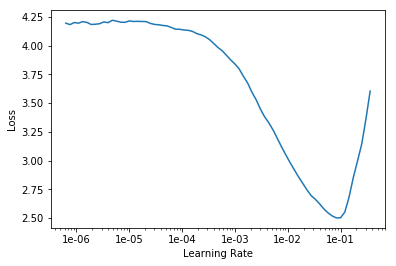

In [29]:
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.726196,0.275373,0.078484,03:22
1,0.426497,0.270030,0.094723,03:35
2,0.324324,0.219348,0.071719,03:32
3,0.278480,0.192218,0.062246,03:33
4,0.225945,0.193504,0.061570,03:40
5,0.155291,0.168902,0.054127,03:42
6,0.123951,0.160021,0.050068,03:42
7,0.089605,0.159096,0.050744,03:35


In [31]:
learn.save('stage-1-50')

fine-tuning:

In [32]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.118016,0.160316,0.048714,03:55
1,0.099878,0.158538,0.047361,03:55
2,0.083368,0.157440,0.048038,03:55


In [33]:
learn.load('stage-1-50');

In [34]:
interp = ClassificationInterpretation.from_learner(learn)

In [35]:
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 7),
 ('Egyptian_Mau', 'Bengal', 5),
 ('american_bulldog', 'staffordshire_bull_terrier', 5),
 ('staffordshire_bull_terrier', 'american_bulldog', 5),
 ('Bengal', 'Egyptian_Mau', 4),
 ('Russian_Blue', 'British_Shorthair', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('Birman', 'Ragdoll', 2),
 ('British_Shorthair', 'Russian_Blue', 2),
 ('Siamese', 'Birman', 2),
 ('beagle', 'basset_hound', 2),
 ('chihuahua', 'miniature_pinscher', 2)]

## Other data formats

In [36]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/tmp/.fastai/data/mnist_sample')

In [37]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26, num_workers=0)

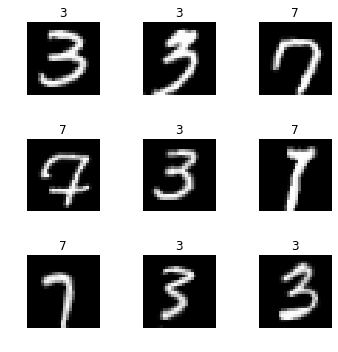

In [38]:
data.show_batch(rows=3, figsize=(5,5))

In [39]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)
learn.fit(2)

/opt/conda/lib/python3.6/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/.torch/models/resnet18-5c106cde.pth
46827520it [00:00, 110973605.09it/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.165285,0.081867,0.970559,00:25
1,0.112950,0.046887,0.984298,00:24


In [40]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [41]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28, num_workers=0)

[0, 1]

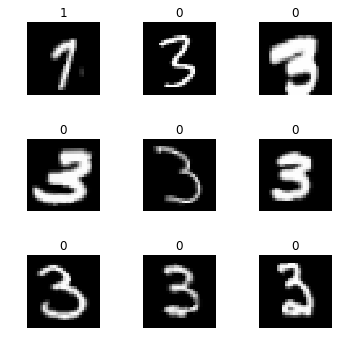

In [42]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [43]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24, num_workers=0)
data.classes

[0, 1]

In [44]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/tmp/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/tmp/.fastai/data/mnist_sample/train/3/21102.png')]

In [45]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24, num_workers=0)
data.classes

['3', '7']

In [46]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7', num_workers=0)
data.classes

['3', '7']

In [47]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [48]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24, num_workers=0)
data.classes

['3', '7']